In [ ]:
!pip install matplotlib
!pip install pyglet==1.2.4

## outline & summary

当谈到PPO（Proximal Policy Optimization）算法时，有几个不同的公式描述。下面是其中一种常见的形式：

首先，我们定义一些符号：

- $\theta$ 表示策略函数的参数。
- $s$ 表示环境的状态。
- $a$ 表示在状态 $s$ 下采取的动作。
- $r$ 表示从环境中获得的奖励。
- $s'$ 表示转移到的下一个状态。
- $A(s, a)$ 表示状态动作对 $(s, a)$ 的优势估计。

PPO算法的目标是最大化一个被称为“修剪的目标函数”的表达式。修剪的目标函数的公式如下：

$$
L^{CLIP}(\theta) = \hat{\mathbb{E}}_t\left[\min\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)} A(s_t, a_t), \text{clip}\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}, 1 - \epsilon, 1 + \epsilon\right) A(s_t, a_t)\right)\right]
$$

其中 $\pi_\theta(a_t|s_t)$ 表示在参数为 $\theta$ 的策略下，在状态 $s_t$ 时选择动作 $a_t$ 的概率。$\pi_{\theta_{\text{old}}}(a_t|s_t)$ 表示旧的策略在相同的状态 $s_t$ 时选择动作 $a_t$ 的概率。$\epsilon$ 是一个超参数，用于控制修剪的程度。

在每次更新步骤中，我们使用梯度上升方法来优化目标函数。具体而言，我们最小化负的修剪的目标函数，如下所示：

$$
\theta_{\text{new}} = \arg\min_\theta -L^{CLIP}(\theta)
$$


在实际的算法中，通常还会使用价值函数的近似和一些正则化项，以增强算法的稳定性和收敛性。此外，PPO算法还使用多个采样轨迹进行训练，并在每次更新步骤中重复执行这些轨迹。

需要注意的是，这只是PPO算法的一个公式表示，并不包括所有的细节和实现的变体。在实际应用中，可能会使用其他改进和调整来适应具体问题的需求。

## 2 policy network

In [119]:
import torch
from torch import nn
from torch import optim
from torch import autograd
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical



In [120]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_states, num_actions, hidden_size, learning_rate=3e-4):
        # super(PolicyNetwork, self).__init__()
        # self.num_actions = num_actions
        # self.fc1 = nn.Linear(num_states, hidden_size)
        # self.fc2 = nn.Linear(hidden_size, hidden_size)
        # self.fc_pi = nn.Linear(hidden_size, num_actions)
        # self.fc_v = nn.Linear(hidden_size, 1)
        super(PolicyNetwork, self).__init__()
        self.data = []

        self.fc1 = nn.Linear(num_states, hidden_size)
        self.fc_pi = nn.Linear(hidden_size, num_actions)
        self.fc_v = nn.Linear(hidden_size, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim=0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v


## 3. update policy

- $L^{CLIP}(\theta) = \hat{\mathbb{E}}_t\left[\min\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)} A(s_t, a_t), \text{clip}\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}, 1 - \epsilon, 1 + \epsilon\right) A(s_t, a_t)\right)\right]$
- new_log_probs= $\pi_\theta\left(a_t|s_t\right) $
- ratio = $\frac{\pi_\theta\left(a_t|s_t\right)}{\pi_{\theta_{old}}\left(a_t|s_t\right)} $
- cliped_ratio = $\text{clip}\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)},1-\epsilon,1+\epsilon\right)$

In [167]:
from torch.distributions import Categorical

epsilon = 0.1
ppo_epochs = 3
value_loss_coeff = 0.5  # 值函数损失系数
entropy_coeff = 0.01  # 策略熵惩罚系数
GAMMA = 0.98  # 折扣因子
lmbda = 0.95  # GAE参数



def update_ppo(policy_network, optimizer, states, actions, rewards, next_states, log_probs, done):
    # for i in range(ppo_epochs):
    #     td_target = rewards + GAMMA * policy_network.v(next_states) * done
    #     delta = td_target - policy_network.v(states)
    #     delta = delta.detach().numpy()

    #     advantage_lst = []
    #     advantage = 0.0
    #     for delta_t in delta[::-1]:
    #         advantage = GAMMA * lmbda * advantage + delta_t[0]
    #         advantage_lst.append([advantage])
    #     advantage_lst.reverse()
    #     advantage = torch.tensor(advantage_lst, dtype=torch.float)

    #     pi = policy_network.pi(states, softmax_dim=1)
    #     pi_a = pi.gather(1, actions)
    #     ratio = torch.exp(torch.log(pi_a) - torch.log(log_probs))

    #     surr1 = ratio * advantage
    #     surr2 = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantage
    #     loss = -torch.min(surr1, surr2) + \
    #         F.smooth_l1_loss(policy_network.v(states), td_target.detach())

    #     optimizer.zero_grad()
    #     loss.mean().backward()
    #     optimizer.step()
    for i in range(ppo_epochs):
        # (1,2)
        td_target = rewards + GAMMA * policy_network.v(next_states) * done
        delta = td_target - policy_network.v(states)
        delta = delta.detach().numpy()

        advantages = []
        advantage = 0.0
        for delta_t in delta[::-1]:
            advantage = GAMMA * lmbda * advantage + delta_t[0]
            advantages.append([advantage])
        advantages.reverse()
        advantages_tensor = torch.tensor(advantages).float()

        pi = policy_network.pi(states, softmax_dim=1)
        pi_a = pi.gather(1, actions)

        # 计算策略熵的惩罚项
        entropy = Categorical(pi).entropy().mean()


        # ratio = $\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$
        ratios = torch.exp(torch.log(pi_a)-torch.log(log_probs))
        cliped_ratios = torch.clamp(ratios, 1-epsilon, 1+epsilon)

        # surrogate loss
        surrogate_loss = - \
            torch.min(ratios*advantages_tensor,
                      cliped_ratios*advantages_tensor).mean()
        # value loss
        # (1,1) -> (1,1)
        value_loss = F.smooth_l1_loss(policy_network.v(states), td_target.detach())

        # total loss
        loss = (surrogate_loss + value_loss_coeff*value_loss)

        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## 4. 创建环境

In [164]:
import gym
env = gym.make('CartPole-v0')
env.observation_space,env.action_space
env.observation_space.shape[0]

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


4

In [165]:
def make_batch(data):
    s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
    for transition in data:
        s, a, r, s_prime, prob_a, done = transition

        s_lst.append(s)
        a_lst.append([a])
        r_lst.append([r])
        s_prime_lst.append(s_prime)
        prob_a_lst.append([prob_a])
        done_mask = 0 if done else 1
        done_lst.append([done_mask])

    s, a, r, s_prime, prob_a, done_mask = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
        torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
        torch.tensor(prob_a_lst, dtype=torch.float), torch.tensor(
            done_lst, dtype=torch.float)
    return s, a, r, s_prime, prob_a, done_mask

In [168]:
policy_network = PolicyNetwork(
    env.observation_space.shape[0], env.action_space.n, 128)
optimizer = optim.Adam(policy_network.parameters(), lr=0.0005)

max_episode_num = 2000
max_steps = 500
train_batch = 50

num_steps = []
avg_num_steps = []
all_rewards = []

for episode in range(max_episode_num):
    state, _ = env.reset()
    done = False
    step = 0
    rewards = []
    while not done:
        data = []
        for batch in range(train_batch):
            step += 1
            # for step in range(max_steps):
            prob = policy_network.pi(torch.from_numpy(state).float())
            m = Categorical(prob)
            a = m.sample().item()
            # log_prob = policy_network.pi(torch.from_numpy(state).float())
            # action = Categorical(log_prob).sample().item()
            next_state, reward, done, _, _ = env.step(a)

            # print(prob.shape, prob, a,prob[a].item())

            # 收集样本
            rewards.append(reward)
            data.append((state, a, reward, next_state, prob[a].item(), done))
            state = next_state
            if done:
                break

        # train
        update_ppo(policy_network, optimizer, *make_batch(data))

    num_steps.append(step)
    avg_num_steps.append(np.mean(num_steps[:]))
    total_reward = np.sum(rewards)
    all_rewards.append(total_reward)
    if episode % 40 == 0:
        print(
            f'episode: {episode}, total reward: {total_reward}, average_reward: {np.mean(all_rewards)}, length: {step}')

episode: 0, total reward: 19.0, average_reward: 19.0, length: 19
episode: 40, total reward: 19.0, average_reward: 17.48780487804878, length: 19
episode: 80, total reward: 12.0, average_reward: 17.679012345679013, length: 12
episode: 120, total reward: 10.0, average_reward: 17.710743801652892, length: 10
episode: 160, total reward: 45.0, average_reward: 22.53416149068323, length: 45
episode: 200, total reward: 104.0, average_reward: 32.86069651741293, length: 104
episode: 240, total reward: 27.0, average_reward: 42.83817427385892, length: 27
episode: 280, total reward: 169.0, average_reward: 57.0355871886121, length: 169
episode: 320, total reward: 80.0, average_reward: 81.18068535825545, length: 80
episode: 360, total reward: 492.0, average_reward: 101.22714681440443, length: 492
episode: 400, total reward: 401.0, average_reward: 108.38154613466334, length: 401
episode: 440, total reward: 165.0, average_reward: 231.14512471655328, length: 165
episode: 480, total reward: 122.0, average_

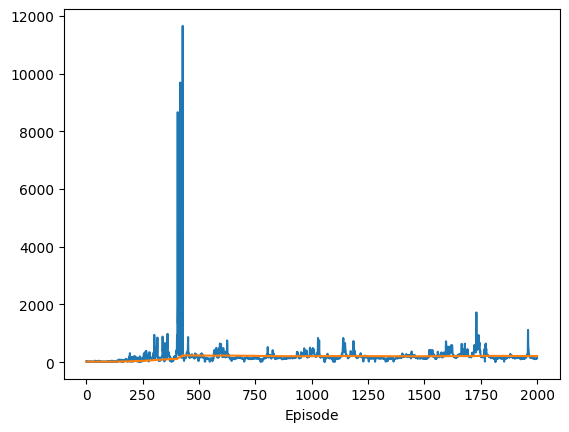

In [169]:
from matplotlib import pyplot as plt

plt.plot(num_steps)
plt.plot(avg_num_steps)
plt.xlabel('Episode')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


# def display_frames_to_video(frames, name):
plt.figure(figsize=(frames[0].shape[0]/72, frames[0].shape[1]/72), dpi=72)
patch = plt.imshow(frames[0])

def animate(i):
    patch.set_data(frames[i])
anim = animation.FuncAnimation(
    plt.gcf(), animate, frames=range(len(frames)), interval=50)
anim.save(f"xx.gif")
# HTML(anim.to_jshtml())

# display_frames_to_video(frames=frames, name="xx")